In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Введение

In [22]:
file_path = "data (2).xlsx"
read_df = pd.read_excel(file_path)
df = read_df[1:].T[4:60].rename(columns = {1:"Year" ,2:"USA", 3:"France"}).reset_index(drop=True)
for col in df:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Исходные данные

тут насрать текста 

# Основные компоненты временного ряда

## 3.1

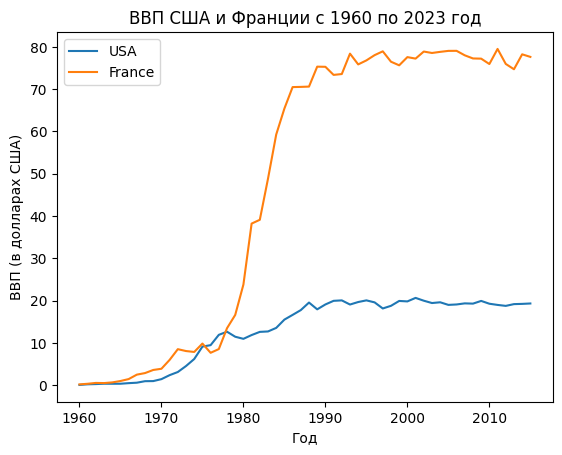

In [23]:
df.plot(x='Year', y=['USA', 'France'], kind='line')
plt.title('ВВП США и Франции с 1960 по 2023 год')
plt.ylabel('ВВП (в долларах США)')
plt.xlabel('Год')
plt.show()


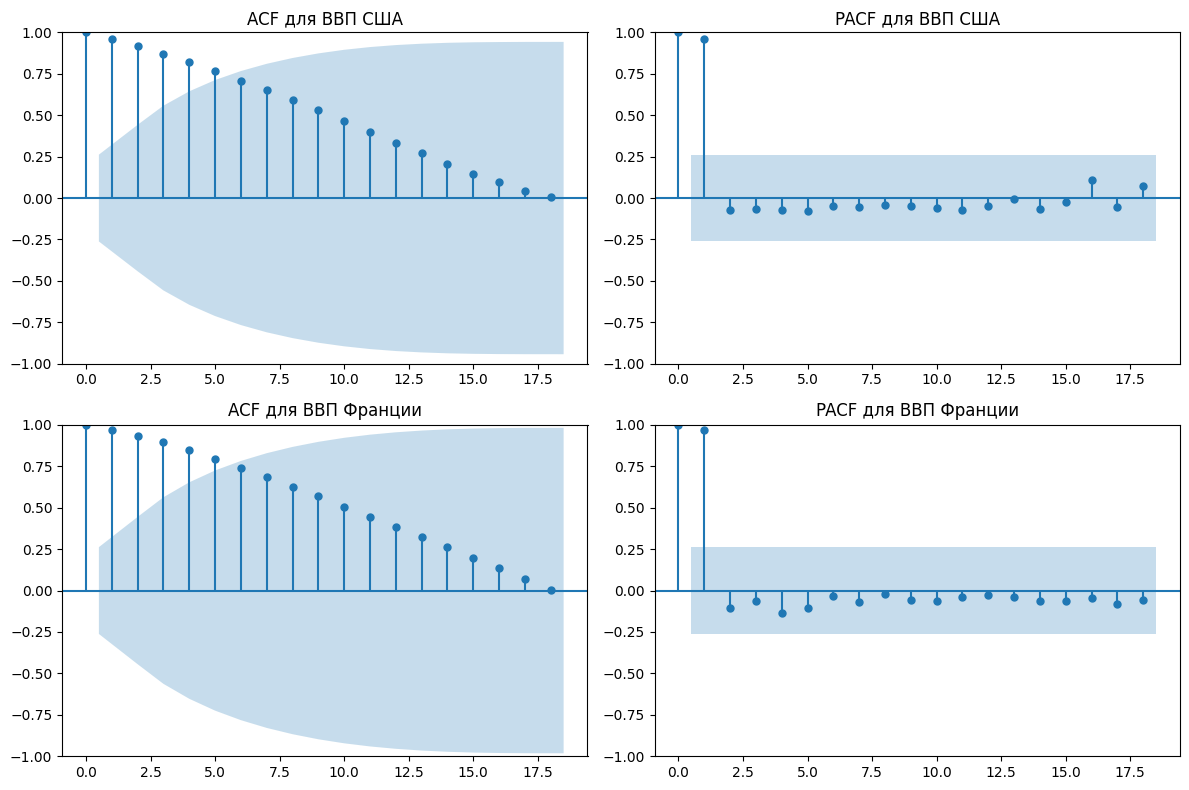

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF для США
plot_acf(df['USA'].values.squeeze(), ax=axes[0, 0], title='ACF для ВВП США')

# PACF для США
plot_pacf(df['USA'].values.squeeze(), ax=axes[0, 1], title='PACF для ВВП США')

# ACF для Франции
plot_acf(df['France'], ax=axes[1, 0], title='ACF для ВВП Франции')

# PACF для Франции
plot_pacf(df['France'], ax=axes[1, 1], title='PACF для ВВП Франции')

# Настройка расположения графиков
plt.tight_layout()
plt.show()



## 3.2

In [25]:
from statsmodels.tsa.stattools import kpss

# Для США
kpss_test_usa = kpss(df['USA'])
print('KPSS Statistic: %f' % kpss_test_usa[0])
print('p-value: %f' % kpss_test_usa[1])
print('Critical Values:')
for key, value in kpss_test_usa[3].items():
    print('\t%s: %.3f' % (key, value))

# Для Франции
kpss_test_france = kpss(df['France'])
print('KPSS Statistic: %f' % kpss_test_france[0])
print('p-value: %f' % kpss_test_france[1])
print('Critical Values:')
for key, value in kpss_test_france[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 1.059654
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Statistic: 1.072875
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


тут насрать текста

## 3.3

In [26]:
y = df['USA']  # Временной ряд ВВП США
n = len(y)
X = np.column_stack([np.ones(n), np.arange(1, n+1)])
beta = np.linalg.inv(X.T @ X) @ X.T @ y
y_fit = X @ beta
residuals = y - y_fit
cumulative_sum = np.cumsum(residuals - np.mean(residuals))

y_france = df['France']  # Временной ряд ВВП Франции
n_france = len(y_france)
X_france = np.column_stack([np.ones(n_france), df['Year']])
beta_france = np.linalg.inv(X_france.T @ X_france) @ X_france.T @ y_france
y_france_fit = X_france @ beta_france
residuals_france = y_france - y_france_fit

cumulative_sum_france = np.cumsum(residuals_france - np.mean(residuals_france))

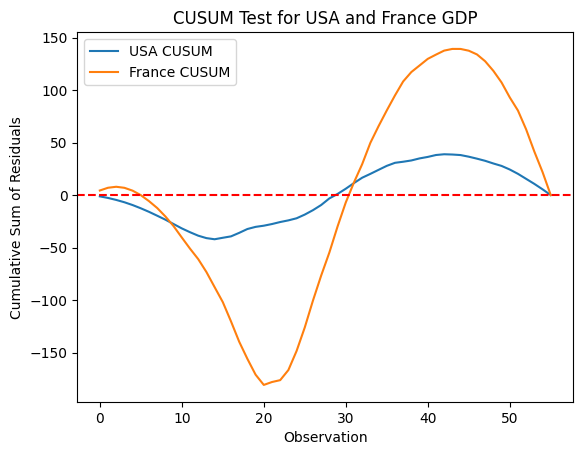

In [27]:
# График ВВП США
plt.plot(cumulative_sum, label='USA CUSUM')

# График ВВП Франции
plt.plot(cumulative_sum_france, label='France CUSUM')

# Добавляем горизонтальную линию на уровне 0 для ориентира
plt.axhline(y=0, color='r', linestyle='--')

# Настраиваем график
plt.title('CUSUM Test for USA and France GDP')
plt.xlabel('Observation')
plt.ylabel('Cumulative Sum of Residuals')
plt.legend()

# Отображаем график
plt.show()


In [28]:
import statsmodels.api as sm
from scipy.stats import f

# Определяем точку разрыва, например, 2008 год
breakpoint = 2008

# Отделяем данные для США до и после кризиса
usa_pre = df[df['Year'] < breakpoint]['USA']
usa_post = df[df['Year'] >= breakpoint]['USA']
years_pre = df[df['Year'] < breakpoint]['Year']
years_post = df[df['Year'] >= breakpoint]['Year']

# Регрессия для всего периода
X_full = sm.add_constant(df['Year'])
y_full = df['USA']
model_full = sm.OLS(y_full, X_full).fit()

# Регрессия для периода до кризиса
X_pre = sm.add_constant(years_pre)
y_pre = usa_pre
model_pre = sm.OLS(y_pre, X_pre).fit()

# Регрессия для периода после кризиса
X_post = sm.add_constant(years_post)
y_post = usa_post
model_post = sm.OLS(y_post, X_post).fit()

# Вычисляем сумму квадратов ошибок для каждой модели
ssr_full = model_full.ssr
ssr_pre = model_pre.ssr
ssr_post = model_post.ssr

# Вычисляем F-статистику для теста Чоу
n = len(y_full)  # Общее количество наблюдений
k = 2  # Количество независимых переменных (включая константу)
F = ((ssr_full - (ssr_pre + ssr_post)) / k) / ((ssr_pre + ssr_post) / (n - 2*k))

# Получаем p-value
p_value = 1 - f.cdf(F, k, n - 2*k)
print("USA F-statistic:", F)
print("USA p-value:", p_value)

# Теперь можно повторить те же шаги для данных по Франции
france_pre = df[df['Year'] < breakpoint]['France']
france_post = df[df['Year'] >= breakpoint]['France']

y_full = df['France']
model_full = sm.OLS(y_full, X_full).fit()
y_pre = france_pre
model_pre = sm.OLS(y_pre, X_pre).fit()
y_post = france_post
model_post = sm.OLS(y_post, X_post).fit()

ssr_full = model_full.ssr
ssr_pre = model_pre.ssr
ssr_post = model_post.ssr
F = ((ssr_full - (ssr_pre + ssr_post)) / k) / ((ssr_pre + ssr_post) / (n - 2*k))
p_value = 1 - f.cdf(F, k, n - 2*k)
print("France F-statistic:", F)
print("France p-value:", p_value)


USA F-statistic: 20.521476474465743
USA p-value: 2.693495878558494e-07
France F-statistic: 15.451358037137464
France p-value: 5.411269885402525e-06


Для выявления стационарности ряда часто используют следующие тесты единичного корня:

1. Тест Дики-Фуллера (Dickey-Fuller test)
2. Тест Филлипса-Перрона (Phillips-Perron test)
3. Тест Квятковского-Филлипса-Шмидта-Шина (KPSS test)



In [29]:
from statsmodels.tsa.stattools import adfuller

df.set_index('Year', inplace=True)

# Тест Дики-Фуллера для США
result_usa = adfuller(df['USA'])
print('Тест Дики-Фуллера для США:')
print('ADF Statistic: %f' % result_usa[0])
print('p-value: %f' % result_usa[1])
print('Critical Values:')
for key, value in result_usa[4].items():
    print('\t%s: %.3f' % (key, value))

# Тест Дики-Фуллера для Франции
result_france = adfuller(df['France'])
print('\nТест Дики-Фуллера для Франции:')
print('ADF Statistic: %f' % result_france[0])
print('p-value: %f' % result_france[1])
print('Critical Values:')
for key, value in result_france[4].items():
    print('\t%s: %.3f' % (key, value))

# Интерпретация результатов
def interpret_result(result, country):
    if result[1] > 0.05:
        print(f"Ряд {country} является нестационарным")
    else:
        print(f"Ряд {country} является стационарным")

interpret_result(result_usa, "США")
interpret_result(result_france, "Франции")


Тест Дики-Фуллера для США:
ADF Statistic: -1.773908
p-value: 0.393491
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596

Тест Дики-Фуллера для Франции:
ADF Statistic: -1.688438
p-value: 0.437079
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
Ряд США является нестационарным
Ряд Франции является нестационарным


In [30]:
from arch.unitroot import PhillipsPerron

# Применяем тест Филлипса-Перрона к ряду 'USA'
pp_test_usa = PhillipsPerron(df['USA'])

# Применяем тест Филлипса-Перрона к ряду 'France'
pp_test_france = PhillipsPerron(df['France'])

# Результаты для США
print(pp_test_usa.summary().as_text())

# Результаты для Франции
print(pp_test_france.summary().as_text())




     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.596
P-value                         0.485
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.119
P-value                         0.707
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [31]:
from arch.unitroot import PhillipsPerron
pp_test_usa = PhillipsPerron(df['USA'])

# Применяем тест Филлипса-Перрона к ряду 'France'
pp_test_france = PhillipsPerron(df['France'])

# Результаты для США
print(pp_test_usa.summary().as_text())

# Результаты для Франции
print(pp_test_france.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.596
P-value                         0.485
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.119
P-value                         0.707
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.56 (1%), -2.92 (5%), -2.60 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [32]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, name):
    print(f'Результаты теста KPSS для {name}:')
    statistic, p_value, n_lags, critical_values = kpss(series, 'c')
    print(f'KPSS Статистика: {statistic}')
    print(f'p-value: {p_value}')
    print('Критические значения:')
    for key, value in critical_values.items():
        print(f'    {key} : {value}')
    
    if p_value < 0.05:
        print(f"Вероятность того, что временной ряд {name} не содержит единичный корень и является стационарным, низкая.")
    else:
        print(f"Вероятность того, что временной ряд {name} не содержит единичный корень и является стационарным, высокая.")
    print()
# Применяем тест KPSS к ряду 'USA'
kpss_test(df['USA'], 'USA')

# Применяем тест KPSS к ряду 'France'
kpss_test(df['France'], 'France')

Результаты теста KPSS для USA:
KPSS Статистика: 1.0596536578206779
p-value: 0.01
Критические значения:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Вероятность того, что временной ряд USA не содержит единичный корень и является стационарным, низкая.

Результаты теста KPSS для France:
KPSS Статистика: 1.0728748084993596
p-value: 0.01
Критические значения:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Вероятность того, что временной ряд France не содержит единичный корень и является стационарным, низкая.


так как наши ряды не стационарные, возьмём последовательные разности и рассмотрим их 
todo : переписать красиво

In [33]:
df['dUSA'] = df['USA'].diff().dropna()
df['dFrance'] = df['France'].diff().dropna()
df = df.dropna()

kpss_test(df['dUSA'], 'dUSA')

# Применяем тест KPSS к дифференцированным данным для 'France'
kpss_test(df['dFrance'], 'dFrance')



Результаты теста KPSS для dUSA:
KPSS Статистика: 0.4167303327362794
p-value: 0.0699438220964313
Критические значения:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Вероятность того, что временной ряд dUSA не содержит единичный корень и является стационарным, высокая.

Результаты теста KPSS для dFrance:
KPSS Статистика: 0.2610098205745401
p-value: 0.1
Критические значения:
    10% : 0.347
    5% : 0.463
    2.5% : 0.574
    1% : 0.739
Вероятность того, что временной ряд dFrance не содержит единичный корень и является стационарным, высокая.


todo : тут насрать, что дифы стационарны

## 4.2

### построение модели

                               SARIMAX Results                                
Dep. Variable:                    USA   No. Observations:                   55
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -68.653
Date:                Sun, 07 Apr 2024   AIC                            143.306
Time:                        10:47:35   BIC                            149.273
Sample:                             0   HQIC                           145.607
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9065      0.109      8.302      0.000       0.692       1.120
ma.L1         -0.7305      0.187     -3.901      0.000      -1.098      -0.363
sigma2         0.7401      0.129      5.742      0.0

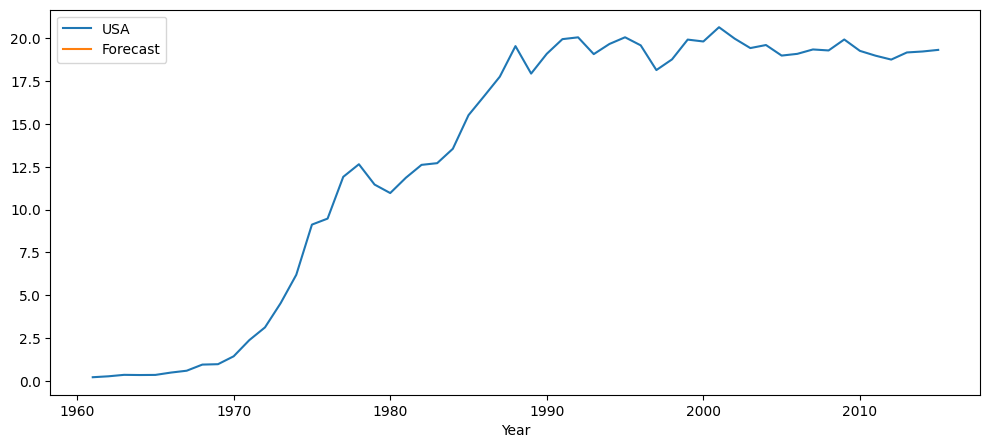

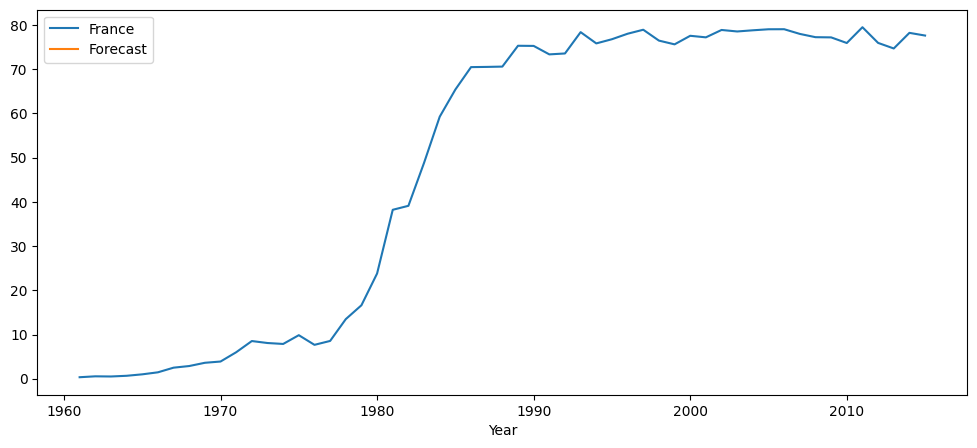

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Функция для подгонки модели ARIMA и вывода результатов
def fit_arima_model(df, column):
    # Создаем и обучаем модель ARIMA
    model = ARIMA(df[column], order=(1, 1, 1))
    results = model.fit()

    # Выводим сводку модели
    print(results.summary())

    # Визуализация фактических и прогнозируемых значений
    df['Forecast'] = results.predict(start=0, end=len(df), typ='levels')
    df[[column, 'Forecast']].plot(figsize=(12, 5))

# Применяем модель ARIMA к колонке 'USA'
fit_arima_model(df, 'USA')

# Применяем модель ARIMA к колонке 'France'
fit_arima_model(df, 'France')


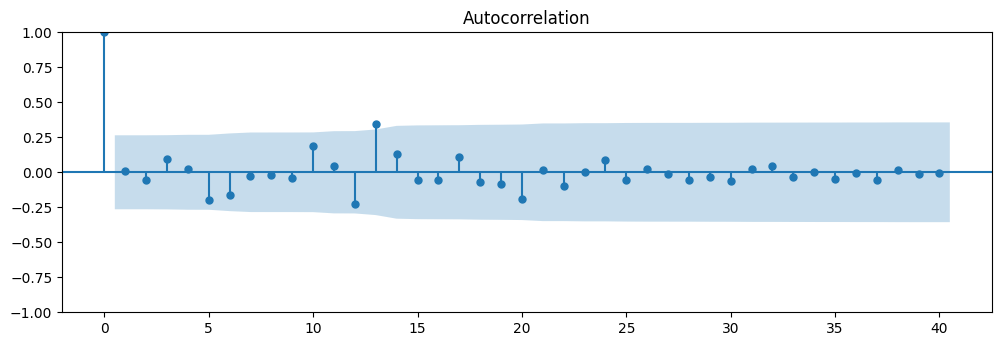

In [40]:

# Диагностика остатков для колонки 'USA'
model = ARIMA(df['USA'], order=(1, 1, 1))
residuals_usa = model.fit().resid
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(residuals_usa, lags=40, ax=fig.add_subplot(211))
plt.show()


### изучаем альтернативные варианты

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
df['Dummy'] = 0
break_point = 2008 
df.loc[df.index >= break_point, 'Dummy'] = 1

results_dict = {}
for column in ['USA', 'France']: 
    results_dict[column] = {}
    # ARIMA(1, 1, 1) без тренда
    model_111 = ARIMA(df[column], order=(1, 1, 1))
    results_111 = model_111.fit()
    results_dict[column]['ARIMA(1, 1, 1)'] = results_111

    # ARIMA(1, 1, 1) с трендом
    model_111_trend = ARIMA(df[column], order=(1, 1, 1), trend='t')
    results_111_trend = model_111_trend.fit()
    results_dict[column]['ARIMA(1, 1, 1) with trend'] = results_111_trend

    # ARIMA(1, 1, 1) со структурным сдвигом
    model_111_dummy = SARIMAX(df[column], order=(1, 1, 1), exog=df['Dummy'])
    results_111_dummy = model_111_dummy.fit()
    results_dict[column]['ARIMA(1, 1, 1) with structural break'] = results_111_dummy

    # Более сложная ARIMA(2, 1, 2) без тренда
    model_212 = ARIMA(df[column], order=(2, 1, 2))
    results_212 = model_212.fit()
    results_dict[column]['ARIMA(2, 1, 2)'] = results_212

    # Сезонная SARIMA(1, 1, 1)(1, 1, 1)[12] - пример для месячных данных
    model_sarima = SARIMAX(df[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results_sarima = model_sarima.fit()
    results_dict[column]['SARIMA(1, 1, 1)(1, 1, 1)[12]'] = results_sarima

# Подготовка результатов к анализу остатков
for name, results in results_dict[column].items():
    df[f'{name}_resid'] = results.resid
    df[f'{name}_predict'] = results.predict(start=df.index[0], end=df.index[-1], dynamic=False)

# Распечатаем сводку для каждой модели
def coutry_res(column):
    for name, results in results_dict[column].items():
        print(f'Results for model {name}:')
        print(results.summary())
        print()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25848D+00    |proj g|=  8.09060D-02

At iterate    5    f=  1.24972D+00    |proj g|=  2.57566D-03

At iterate   10    f=  1.24819D+00    |proj g|=  3.19925D-04

At iterate   15    f=  1.24819D+00    |proj g|=  7.02479D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   5.558D-07   1.248D+00
  F =   1.2481864807305776     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.13968D+00    |proj g|=  8.68180D-02

At iterate   20    f=  1.11944D+00    |proj g|=  6.70863D-03

At iterate   25    f=  1.11872D+00    |proj g|=  1.87419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   6.253D-06   1.119D+00
  F =   1.1187186028529705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83902D+01    |proj g|=  5.19310D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.45305D+00    |proj g|=  6.72415D-04

At iterate   20    f=  2.45303D+00    |proj g|=  4.15753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     23      1     0     0   3.816D-06   2.453D+00
  F =   2.4530305941331276     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03644D+00    |proj g|=  6.13208D+00

At iterate    5    f=  2.05983D+00    |proj g|=  9.86632D-02

At iter

### анализ ошибок

In [68]:
def analyze_residuals(residuals, title):
    print(f"Анализ остатков для {title}")
    
    # Построим график остатков
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f'Residuals Time Series for {title}')
    plt.show()

    # Построим гистограмму остатков
    plt.figure(figsize=(10, 4))
    plt.hist(residuals, bins=30)
    plt.title(f'Residuals Histogram for {title}')
    plt.show()

    # ACF и PACF
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    sm.graphics.tsa.plot_acf(residuals, lags=26, ax=ax[0])
    sm.graphics.tsa.plot_pacf(residuals, lags=26, ax=ax[1])
    plt.show()

    # Тест Льюнга-Бокса
    lb_value, lb_pvalue = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=False)
    print(f'Test Ljung-Box, p-value: {lb_pvalue[0]} \n')

    # Тест на нормальность (Жарка-Бера)
    jb_value, jb_pvalue, skew, kurtosis = sm.stats.jarque_bera(residuals)
    print(f'Test Jarque-Bera, p-value: {jb_pvalue} \n')
    print(f'Skew: {skew} \nKurtosis: {kurtosis} \n')

# Анализ остатков для каждой модели
def model_diffs(column):
    for name, results in results_dict[column].items():
        analyze_residuals(df[f'{name}_resid'], name)


#### США

Анализ остатков для ARIMA(1, 1, 1)


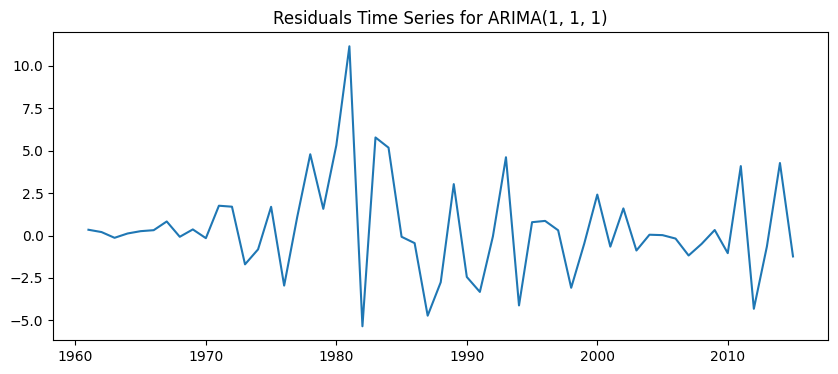

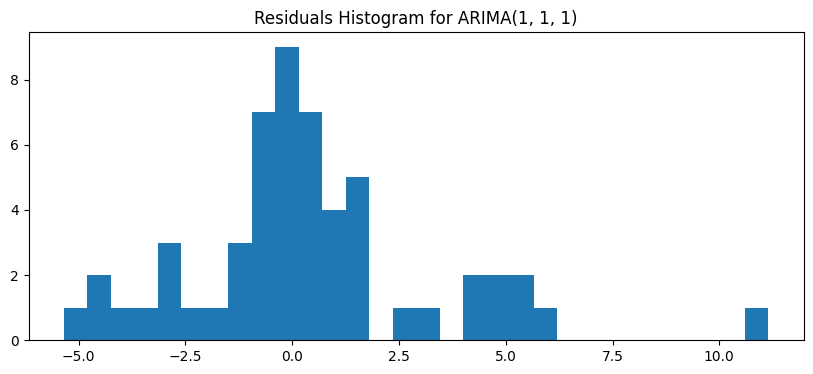

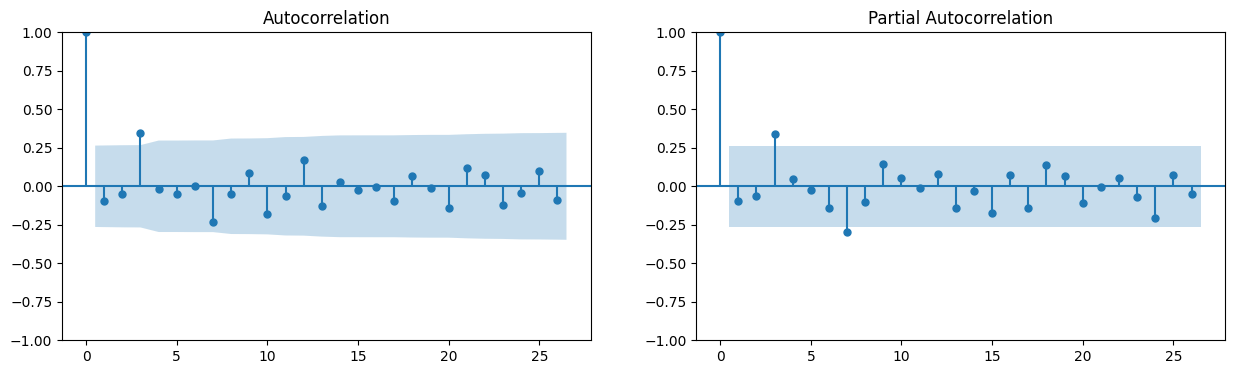

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 5.6263527829074766e-05 

Skew: 0.9199625312080899 
Kurtosis: 5.27040021105106 

Анализ остатков для ARIMA(1, 1, 1) with trend


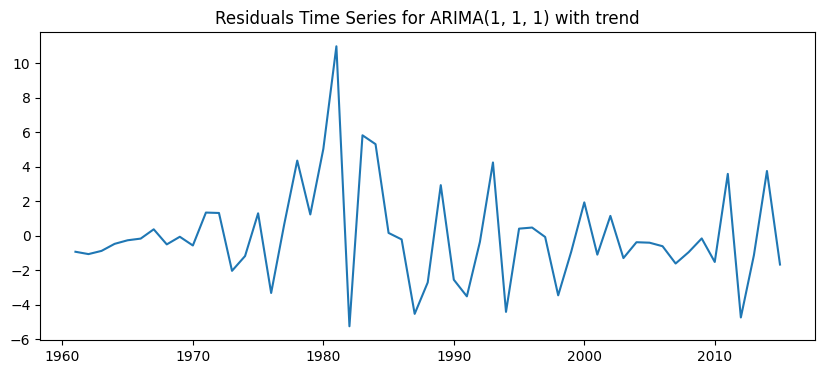

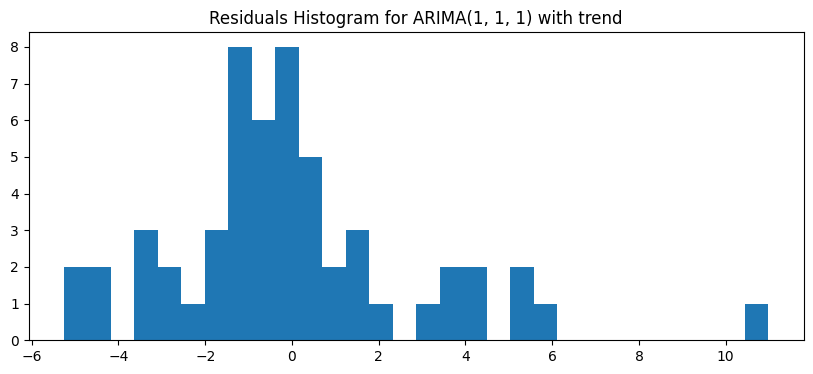

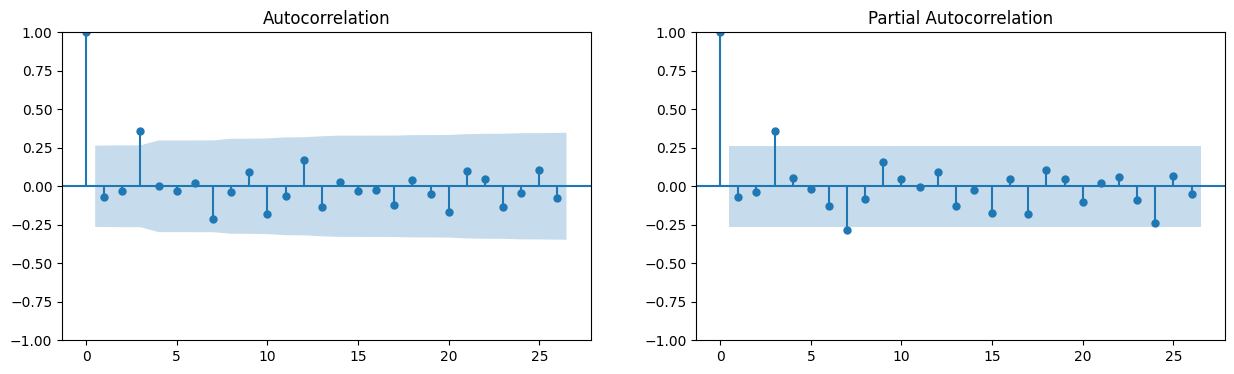

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 3.237181623682459e-06 

Skew: 1.1006784462910626 
Kurtosis: 5.48716812158672 

Анализ остатков для ARIMA(1, 1, 1) with structural break


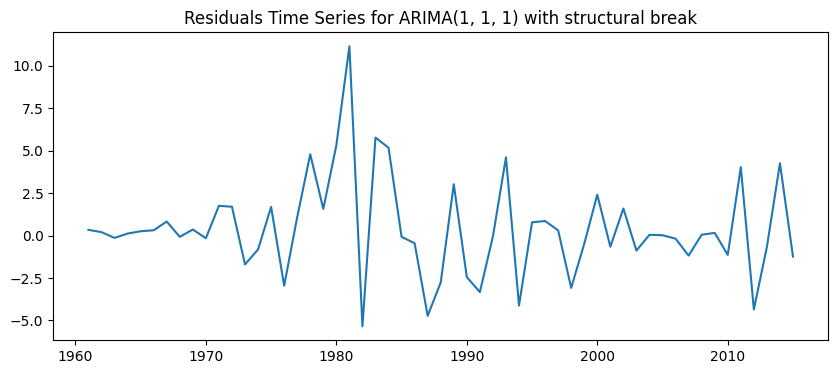

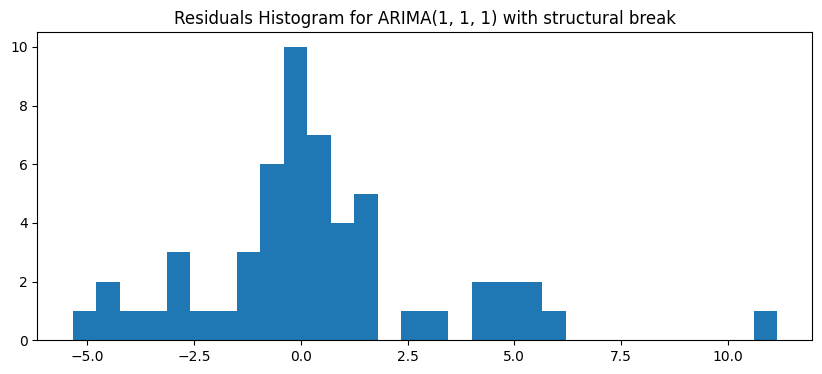

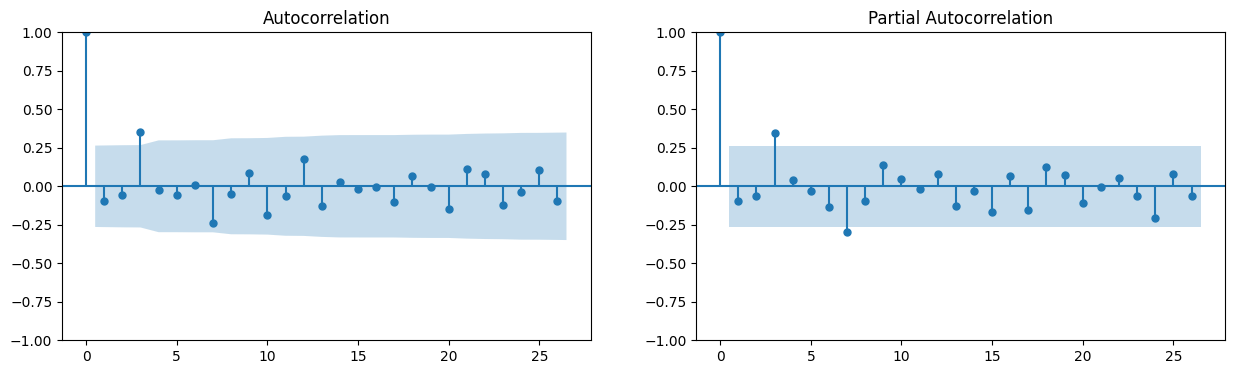

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 5.537378747934025e-05 

Skew: 0.9155062912908494 
Kurtosis: 5.280645895751624 

Анализ остатков для ARIMA(2, 1, 2)


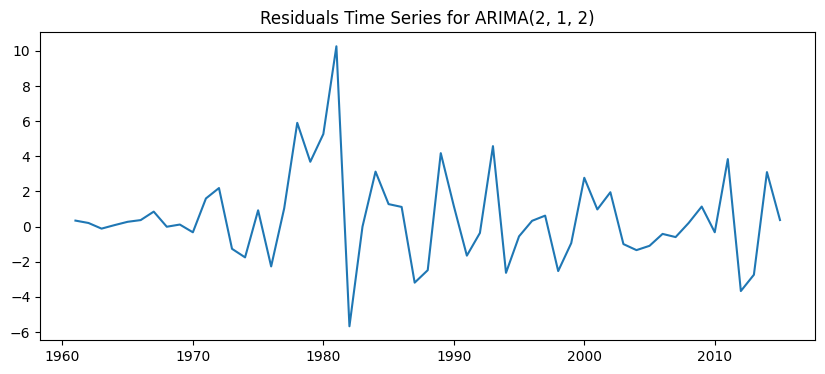

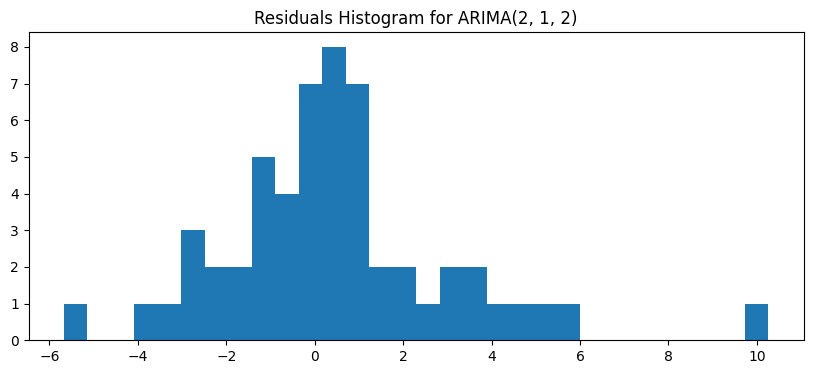

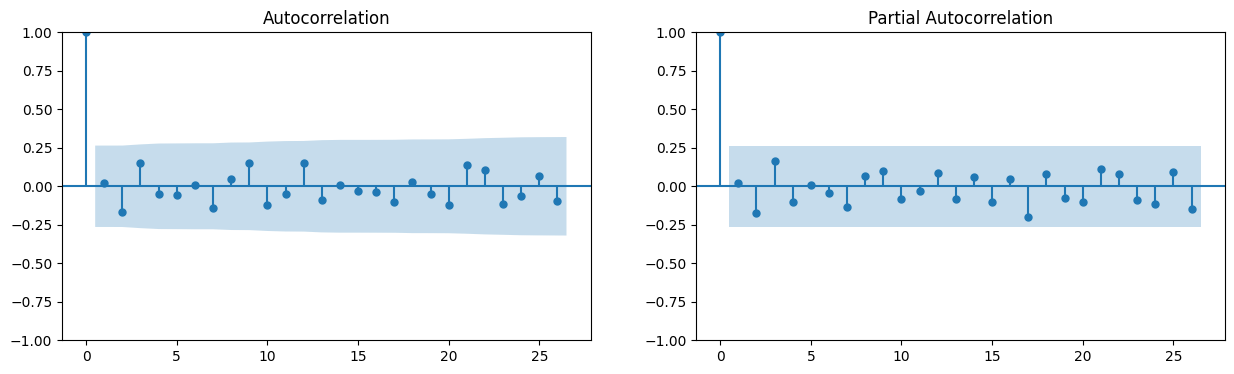

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 1.4809302327752207e-05 

Skew: 0.938033239762373 
Kurtosis: 5.487031245602937 

Анализ остатков для SARIMA(1, 1, 1)(1, 1, 1)[12]


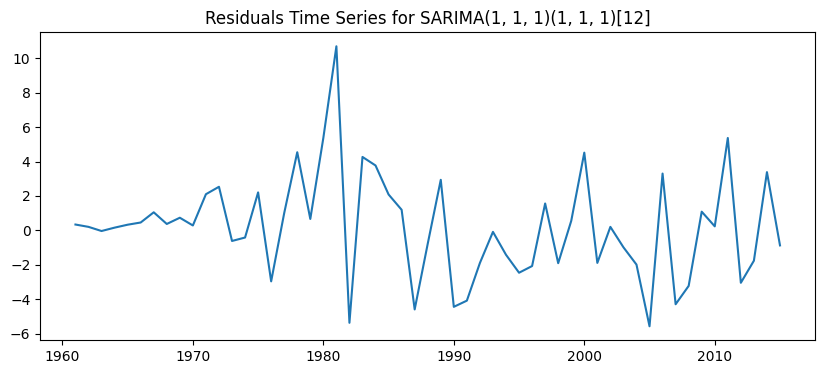

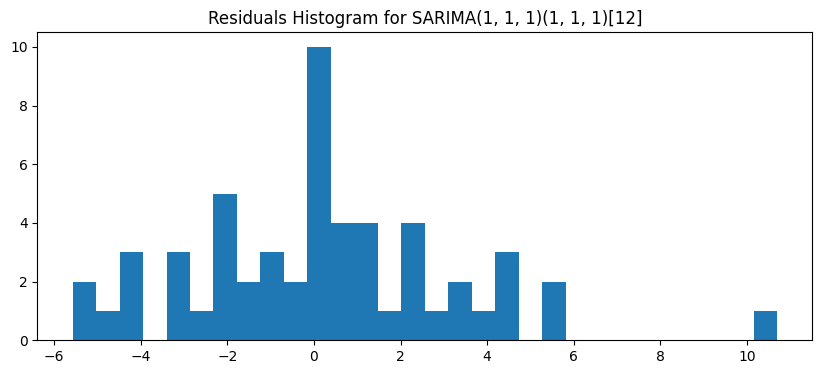

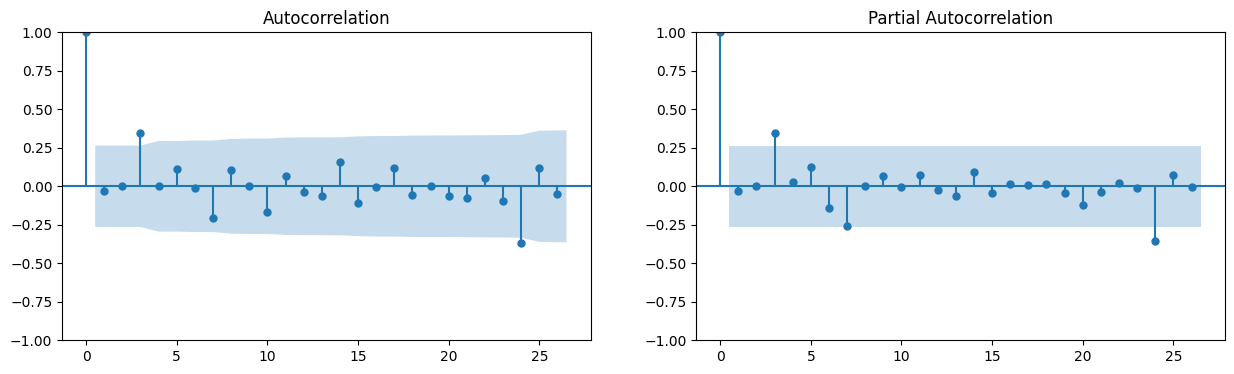

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 0.032935773731818864 

Skew: 0.5962284453106731 
Kurtosis: 4.247732215699894 


In [73]:
model_diffs('USA')

#### Франция

Анализ остатков для ARIMA(1, 1, 1)


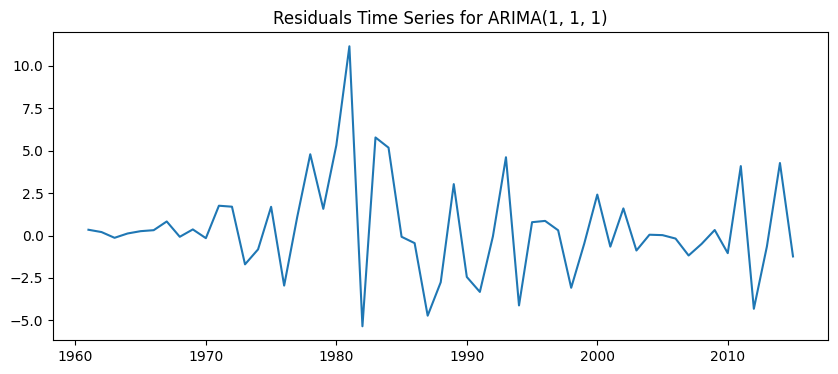

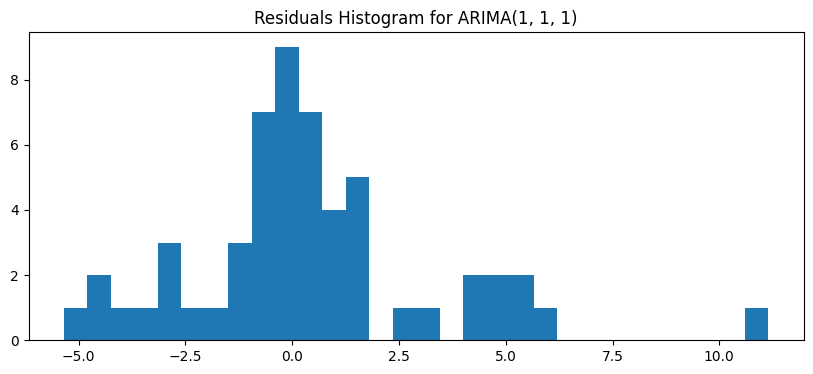

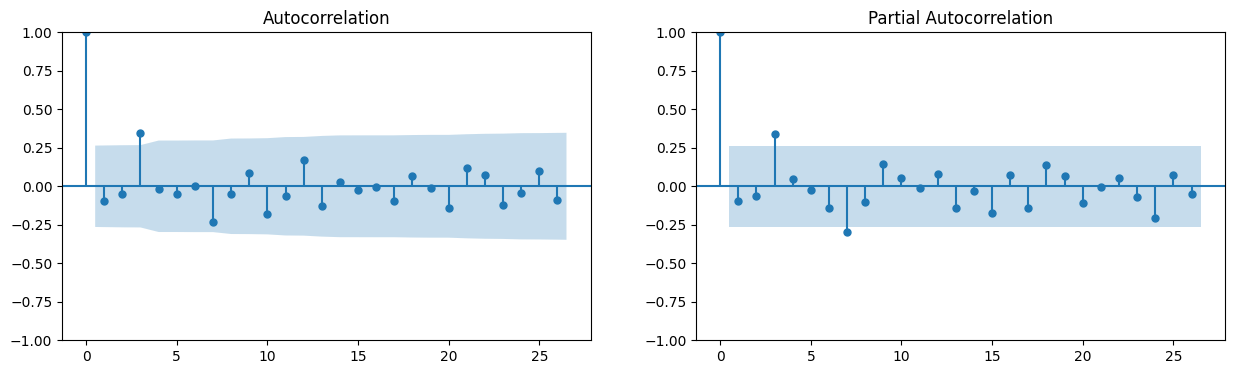

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 5.6263527829074766e-05 

Skew: 0.9199625312080899 
Kurtosis: 5.27040021105106 

Анализ остатков для ARIMA(1, 1, 1) with trend


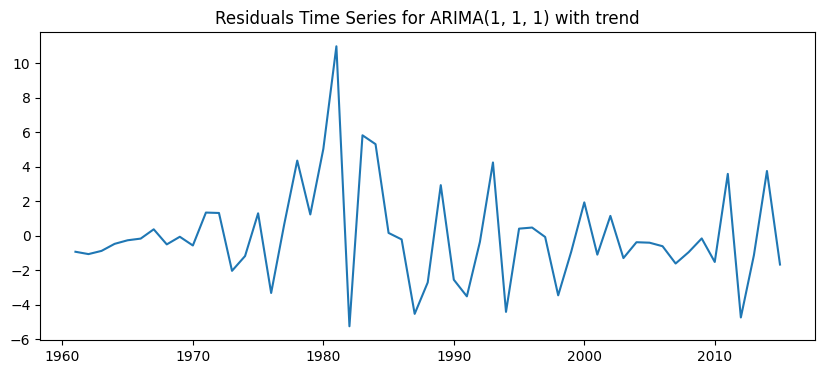

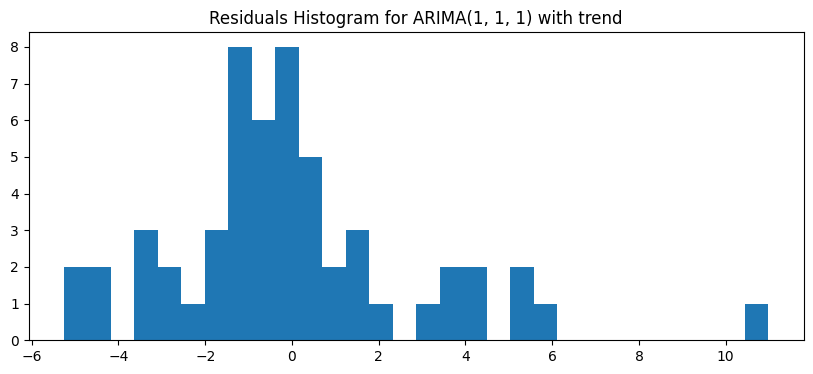

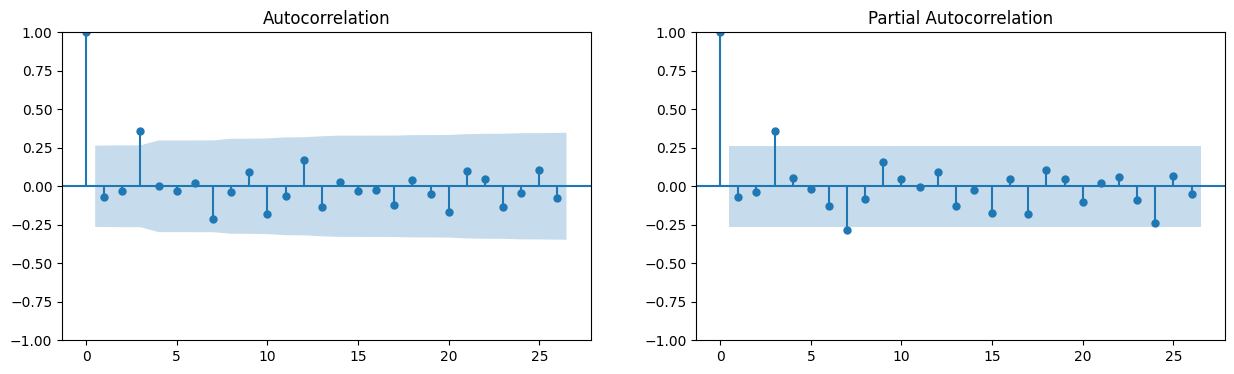

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 3.237181623682459e-06 

Skew: 1.1006784462910626 
Kurtosis: 5.48716812158672 

Анализ остатков для ARIMA(1, 1, 1) with structural break


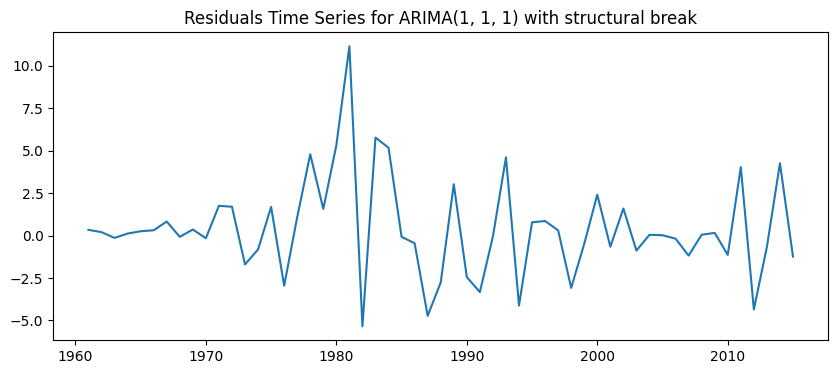

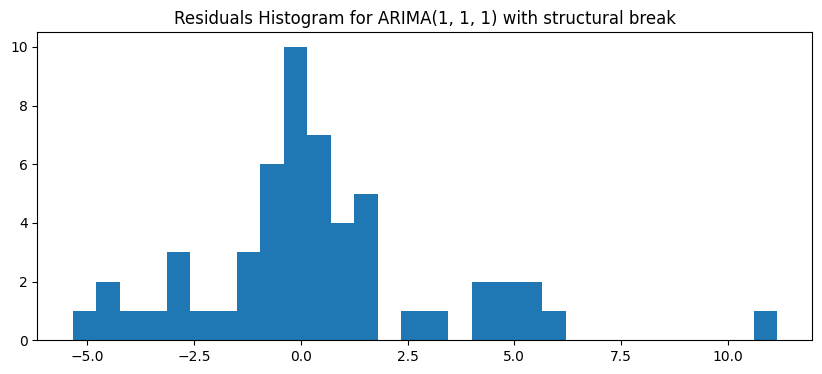

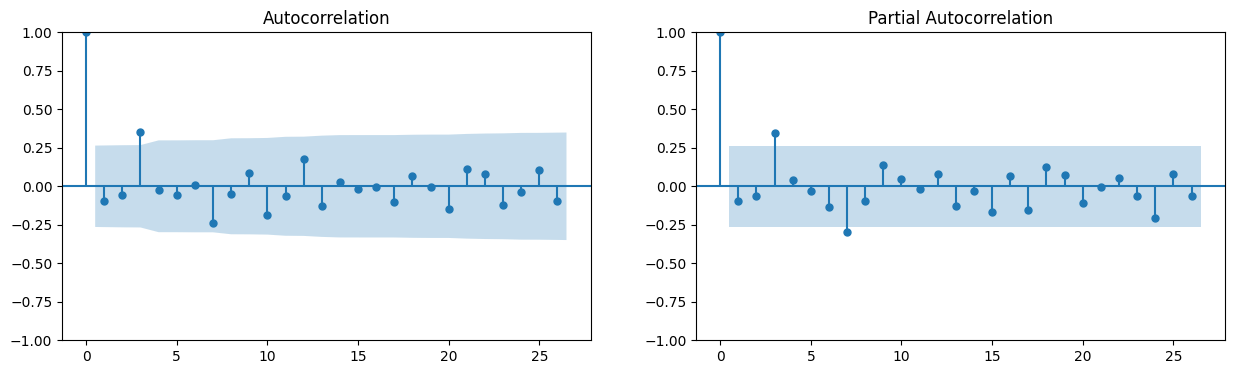

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 5.537378747934025e-05 

Skew: 0.9155062912908494 
Kurtosis: 5.280645895751624 

Анализ остатков для ARIMA(2, 1, 2)


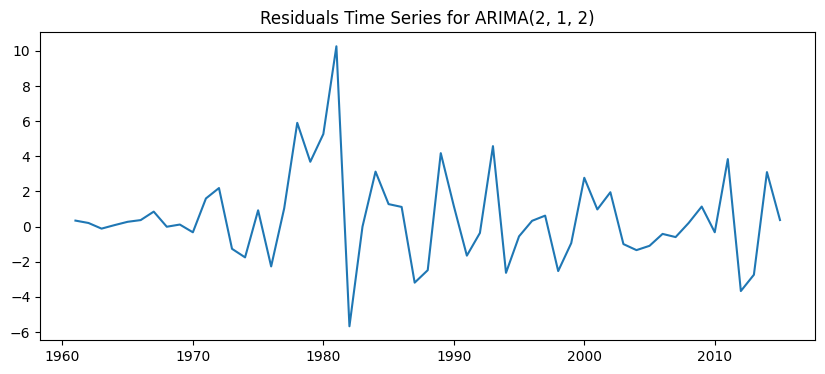

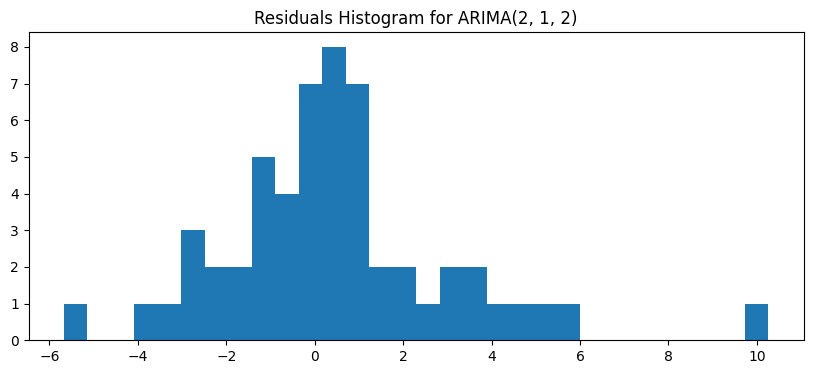

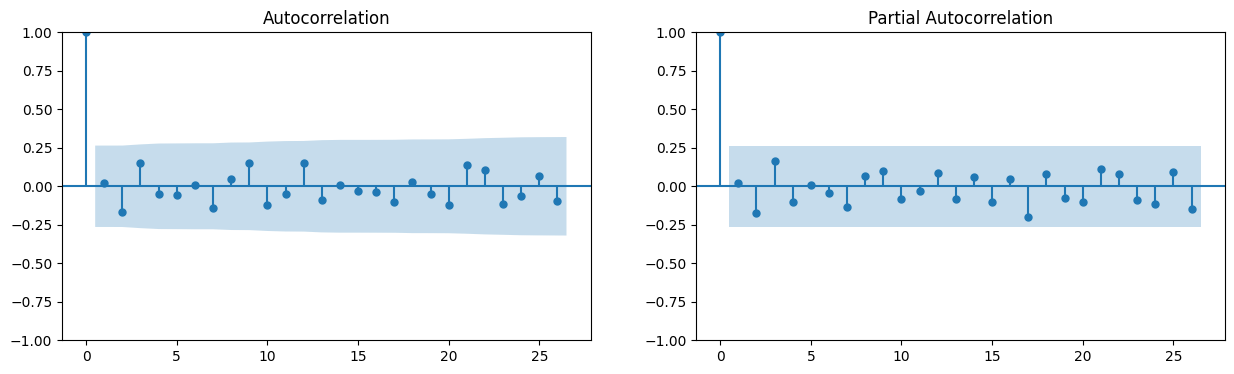

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 1.4809302327752207e-05 

Skew: 0.938033239762373 
Kurtosis: 5.487031245602937 

Анализ остатков для SARIMA(1, 1, 1)(1, 1, 1)[12]


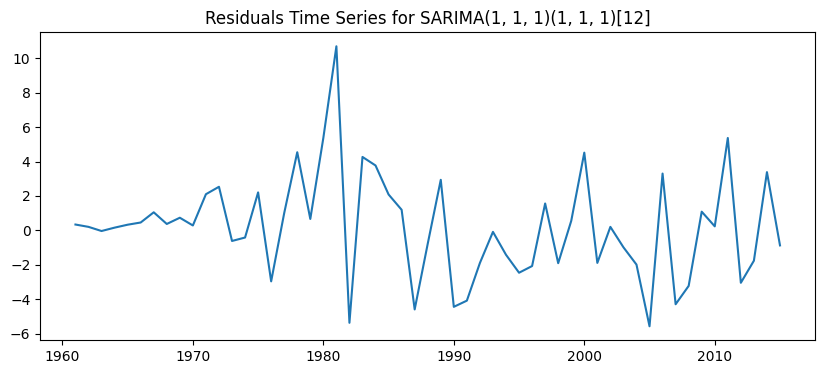

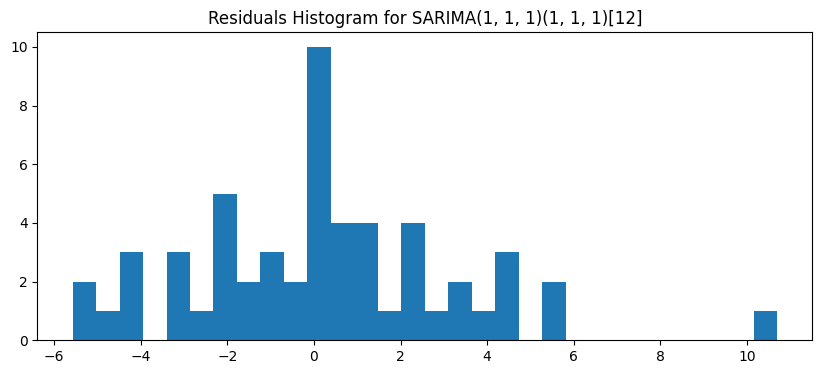

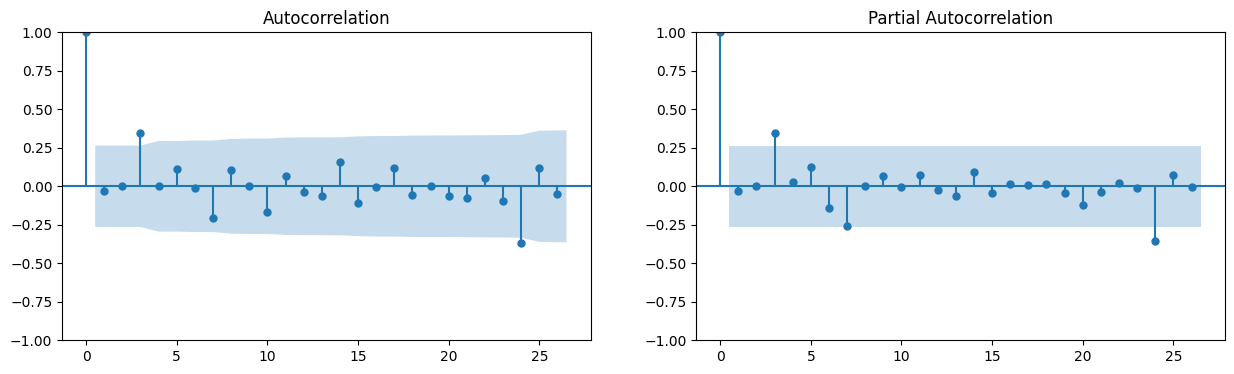

Test Ljung-Box, p-value: l 

Test Jarque-Bera, p-value: 0.032935773731818864 

Skew: 0.5962284453106731 
Kurtosis: 4.247732215699894 


In [74]:
model_diffs('France')

In [77]:
def best_model_by_aic(results_dict, column):
    best_aic = np.inf  # Начальное значение, равно "бесконечности"
    best_model = None
    best_name = None

    # Перебор всех моделей и поиск модели с наименьшим AIC
    for name, results in results_dict[column].items():
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
            best_name = name

    print(f'Лучшая модель по AIC: {best_name} с AIC = {best_aic} для страны {column}')
    return best_model

# Получим лучшую модель на основе AIC
best_models = {}
best_models["USA"] = best_model_by_aic(results_dict, 'USA')
best_models["France"] = best_model_by_aic(results_dict, 'France')


Лучшая модель по AIC: SARIMA(1, 1, 1)(1, 1, 1)[12] с AIC = 133.05904631382677 для страны USA
Лучшая модель по AIC: SARIMA(1, 1, 1)(1, 1, 1)[12] с AIC = 229.93621632522684 для страны France


In [80]:
def get_predictions(column):
    best_model = best_models[column]
    
    # Делаем прогноз на 6 шагов вперед
    forecast_steps = 6
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    predicted_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    
    # Создаем временной ряд датафрейма для прогноза
    dates = pd.date_range(df.index[-1] + 1, periods=forecast_steps)
    forecast_df = pd.DataFrame(index=dates, data=conf_int)
    forecast_df['predicted_mean'] = predicted_mean
    
    # Создаем график исходных данных и предсказанных значений
    plt.figure(figsize=(12, 6))
    plt.plot(df['USA'], label='Исходные данные')
    plt.plot(forecast_df['predicted_mean'], label='Точечный прогноз', color='red')
    
    # Добавляем доверительный интервал
    plt.fill_between(forecast_df.index, 
                     forecast_df.iloc[:, 0], 
                     forecast_df.iloc[:, 1], 
                     color='pink', alpha=0.3, label='95% доверительный интервал')
    
    plt.title('Прогноз ARIMA модели и 95% доверительный интервал')
    plt.legend()
    plt.show()


In [ ]:
todo : ПОДЕБАЖИТЬ

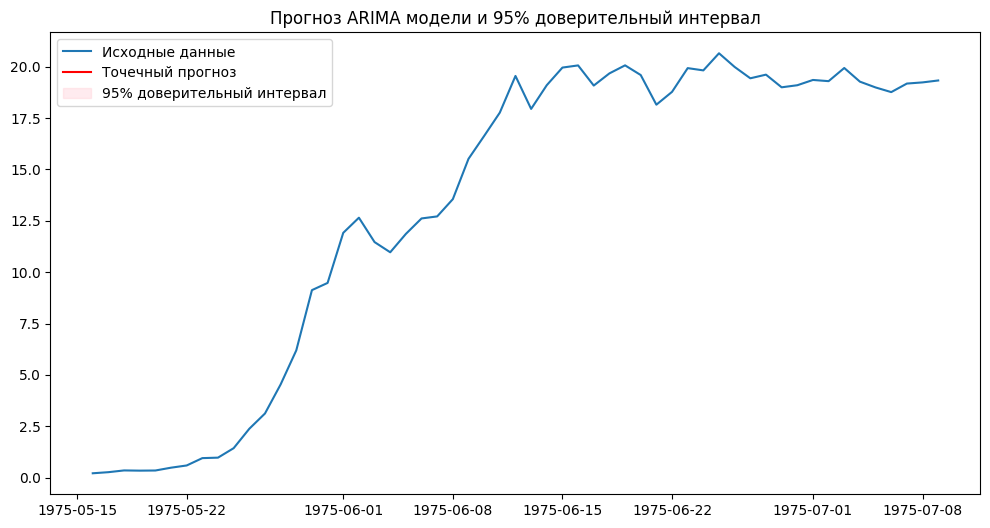

In [81]:
get_predictions('USA')

InvalidIndexError: (slice(None, None, None), 0)

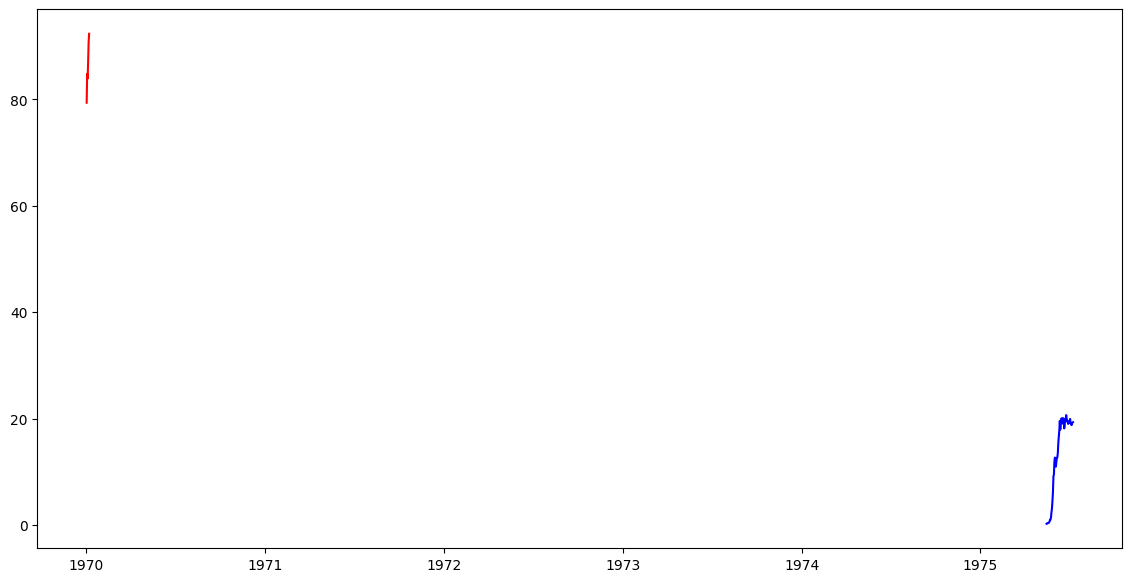

In [83]:
forecast_steps = 6  # Шаги вперед для прогнозирования
best_model = best_models[column]
forecast_result = best_model.get_forecast(steps=forecast_steps)
predicted_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  # 95% доверительный интервал

# Построение совмещенного графика
plt.figure(figsize=(14, 7))

# Исходные данные
plt.plot(df.index, df['USA'], label='Исходные данные', color='blue')

# Точечный прогноз
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, 
                               freq='D')[1:]  # Индекс для предсказанных значений без создания переменной
plt.plot(forecast_index, predicted_mean, label='Точечный прогноз', color='red')

# 95% Доверительный интервал для прогноза
plt.fill_between(forecast_index, 
                 conf_int[:, 0], conf_int[:, 1], 
                 color='pink', alpha=0.3, label='95% доверительный интервал')

# Настраиваем легенду и заголовок
plt.legend()
plt.title('Исходные данные и прогнозы по модели ARIMA')
plt.show()
